In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special

# Binary Metric Elicitation
This notebook aims to reproduce the binary metric elicitation algorithm described by Gaurush et al. (2019).

## The task:
Consider the case of cancer diagnosis, where a doctor's unknown, innate
performance metric is a linear function of the confusion matrix (C):
$\begin{align*}
\phi(C) & = a_{11}TP+a_{01}FP+a_{10}FN+a_{00}TN\\
    & = m_{11}TP+m_{00}TN+m_0
\end{align*}$  
where $m_{11} = (a_{11}-a{10}), m_{00}=(a_{00}-a{01}),  
m_0 = a_{10}\zeta+a_{01}(1-\zeta)$  
for $\zeta = P(Y=1)$

The algorithm of binary metric elicitation is to infer the true parameters for the metric i.e., m00 and m11. Since m11+m00 = 1, the performance metric can be represented as a single parameter $\theta$, s.t. m11, m00 = $cos(\theta), sin(\theta)$. Thus, binary search like algorithm can be performed on $\theta$.


The following code implements the binary elicitation task with synthetic data where the true metric is predefined as m_star.

$\eta(x) = P(Y=1|X=x) = \frac{1}{1+e^{5x}}$, and marginal probability of X ($f_X$) follows uniform distribution in [-1,1].

Gaurush et al. proved that the optimal bayes classifier is
$\bar h(x) =
\left\{
	\begin{array}{ll}
	  1[\eta(x)\ge \frac{m_{00}}{m_{11}+m_{00}}],  & m_{11}+m_{00}\ge 0 \\
		1[\eta(x)\le \frac{m_{00}}{m_{11}+m_{00}}], & o.w.
	\end{array}
\right.$  
Thus,
if m11+m00 >= 0, then  
$TP_m = \frac{1}{2}\int_{-1}^{x'}\frac{1}{1+e^{5x}}dx,\\
TN_m = \frac{1}{2}\int_{x'}^{1}\frac{e^{5x}}{1+e^{5x}}dx$  
if m11+m00 < 0, then  
$TP_m = \frac{1}{2}\int_{x'}^{1}\frac{1}{1+e^{5x}}dx,\\
TN_m = \frac{1}{2}\int_{-1}^{x'}\frac{e^{5x}}{1+e^{5x}}dx$  
for $x'=\Pi_{[-1,1]}\{\frac{1}{5}\ln(\frac{m_{11}}{m_{00}})\}$  
The confusion matrix can then be calculated from TP and TN since TP+FP=$\zeta$,
TN+FN=$1-\zeta$ ($\zeta$=0.5 in this case).

In [ ]:
# true metric
m_star = (-0.94,-0.34) #200 degree
m_star = (0.98,0.17) #11.47 degree

m_star = m_star/np.linalg.norm(m_star)  # normalize
# obtain true theta
t_true = np.arccos(m_star[0])
if t_true > np.pi/2:  # make sure theta either in [0, pi/2] or [pi, 3/2*pi]
    t_true = np.pi*2-t_true

print(t_true)

def eta(x):
  return 1/(1+np.exp(5*x))

zeta = 0.5  # f_X /sim U(-1,1)

# implementation of proposition 1
# return a classifier with t
def h_bar(t):
  m11, m00 = np.cos(t), np.sin(t)
  def hb(x):
    if m11+m00 >= 0:
      return int(eta(x)>=m00/(m11+m00))
    else:
      return int(eta(x)<=m00/(m11+m00))
  return hb

# confusion matrix, analytical solution
def C11(t):  # P(Y=1, h=1)
  m11,m00 = np.cos(t), np.sin(t)
  x_prime = 0.
  h = h_bar(t)
  if m00 == 0:
    x_prime = 1
  elif m11/m00 <= 0:
    x_prime = -1
  else:
    x_prime = np.log(m11/m00)/5
    if x_prime > 1:
      x_prime = 1
    elif x_prime < -1:
      x_prime = -1
  print(x_prime)
  if m00+m11 >= 0:
    return (x_prime-0.2*np.log(1+np.exp(5*x_prime))+1+0.2*np.log(1+np.exp(-5))) # x-0.2ln(1+e^5x)
  else:
    return (1-0.2*np.log(1+np.exp(5))-x_prime+0.2*np.log(1+np.exp(5*x_prime)))

def C10(t):  # P(Y=0, h=1)
  return 1-C11(t)

def C01(t):  # P(Y=1, h=0)
  return 1-C00(t)

def C00(t):  # P(Y=0, h=0)
  m11,m00 = np.cos(t), np.sin(t)
  x_prime = 0
  h = h_bar(t)
  if m00 == 0:
    x_prime = 1
  elif (m00+m11)/m00-1 <= 0:
    x_prime = -1
  else:
    x_prime = np.log(m11/m00)/5
    if x_prime > 1:
      x_prime = 1
    elif x_prime < -1:
      x_prime = -1
  if m00+m11 >= 0:
    return (0.2*np.log(1+np.exp(5))-0.2*np.log(1+np.exp(5*x_prime)))  # ln(1+e^5x)
  else:
    return (0.2*np.log(1+np.exp(5*x_prime))-0.2*np.log(1+np.exp(-5)))

# metric evaluation
def phi(t):
  m11, m00 = np.cos(t_true), np.sin(t_true)
  return m11*C11(t)+m00*C00(t)

# query function (always maximize phi function)
# alpha: error rate —— with probability alpha, the oracle will return wrong answer
def query(t_1, t_2, alpha):
  if phi(t_1) < phi(t_2):
    if np.random.rand() > alpha:
      return 1  # prefer t2
    else:
      return 0
  else:
    if np.random.rand() > alpha:
      return 0  # prefer t1
    else:
      return 1

0.17176015132820346


In [ ]:
C11(2.7)
print(np.cos(1.8),np.sin(1.8))
print(np.cos(2.7),np.sin(2.7))

-1
-0.2272020946930871 0.9738476308781951
-0.9040721420170612 0.4273798802338298


# Algorithm 1
The following function implements the binary search like optimization algorithm. Like standard binary search, the algorithm starts with a range of interest, $\theta_a$ to $\theta_b$, and divides that range into 4 equally seperated intervals. Then by querying the oracle\true_metric on relative preferences between pairs of metrics, the algorithm picks the most favorable interval as the next search range, thus converges to the true metric.

When m11+m00 > 0, $\phi$ is monotonically increasing in both TP and TN, and C is convex, the maximizer must be on the upper boundary. So the starting search range is [0， $\frac{\pi}{2}$].

When m11+m00 < 0, $\phi$ is monotonically decreasing in both TP and TN, the optimal must be on the lower boundary. So the starting search range is [$\pi$， $\frac{3\pi}{2}$].

In [ ]:
# implements algorithm 1
# analytical version
# alpha: error rate of oracle
def max_quasiconcave_metric(eps, alpha):
  t_a = 0
  t_b = np.pi/2
  m_bar = np.zeros(2)
  C_bar = 0
  iter = 0
  while np.linalg.norm(t_a-t_b) > eps:
    # divide the searching range into equally seperated intervals
    t_c = (3*t_a+t_b)/4
    t_d = (t_a+t_b)/2
    t_e = (t_a+3*t_b)/4
    # compute Confusion Matrices
    C_a = np.array([[C00(t_a), C01(t_a)],[C10(t_a), C11(t_a)]])
    C_b = np.array([[C00(t_b), C01(t_b)],[C10(t_b), C11(t_b)]])
    C_c = np.array([[C00(t_c), C01(t_c)],[C10(t_c), C11(t_c)]])
    C_d = np.array([[C00(t_d), C01(t_d)],[C10(t_d), C11(t_d)]])
    C_e = np.array([[C00(t_e), C01(t_e)],[C10(t_e), C11(t_e)]])
    # pairwise comparisons
    ca = query(t_c, t_a, alpha)
    dc = query(t_d, t_c, alpha)
    ed = query(t_e, t_d, alpha)
    be = query(t_b, t_e, alpha)

    # sanity check for out-of-order responses
    if not ca and not dc:
      ca = not ca
    if not dc and not dc:
      

    # determine the next iter search range based on oracle resposne to query
    if ca:
      t_b = t_d
    elif not ca and dc:
      t_b = t_d
    elif not dc and ed:
      t_a = t_c
      t_b = t_e
    elif not ed and be:
      t_a = t_d
    else:
      t_a = t_d
    m_bar[0], m_bar[1] = np.cos(t_d), np.sin(t_d)
    C_bar = C_d
    iter += 1
  # print("iteration run:"+str(iter))
  return m_bar,C_bar

In [ ]:
m,C = max_quasiconcave_metric(1e-4, 0.)
print("true metric: "+str(m_star))
print("elicited metric: "+str(m))
print("confusion matrix: \n"+str(C))

true metric: (0.98, 0.1989974874213242)
elicited metric: [0.97999176 0.19903806]
confusion matrix: 
[[0.32277642 0.17722358]
 [0.01781877 0.48218123]]


# Visualize $\phi(C)$

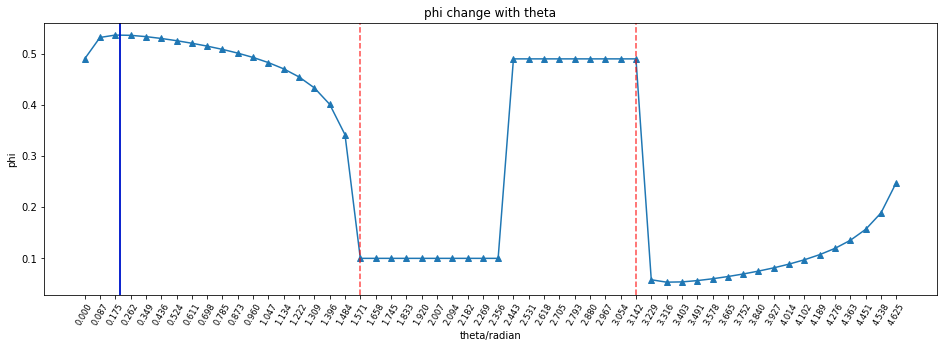

In [ ]:
# Plot phi function versus different thetas
ph = []
for i in np.arange(0, np.pi*1.5, np.pi/36):
  ph.append(phi(i))

plt.figure(figsize=(16,5))
plt.plot(np.arange(0, np.pi*1.5, np.pi/36), ph, "^-")
for p in np.arange(0.5, 1.5, 0.5):
  plt.axvline(x=np.pi*p, c='r', ls='--', alpha=0.7)
plt.axvline(x=t_true, c='g')
t_elicited = np.arccos(m[0])
if t_elicited > np.pi/2:  # make sure theta either in [0, pi/2] or [pi, 3/2*pi]
    t_elicited = np.pi*2-t_elicited
plt.axvline(x=t_elicited, c='b')
# plt.axvline(x=np.arccos(np.pi/4), c='black')
plt.xticks(np.arange(0, np.pi*1.5, np.pi/36), rotation=60, size="small")
plt.title("phi change with theta")
plt.xlabel("theta/radian")
plt.ylabel("phi")
plt.show()

# Experiments on effect of possibly wrong oracle

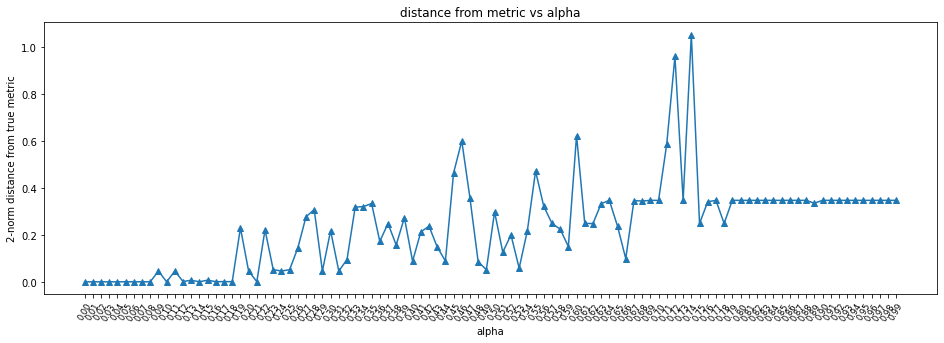

In [ ]:
re = []
step = 0.01
t_true = np.arccos(m_star[0])
if t_true > np.pi/2:
    t_true = np.pi*2-t_true
for al in np.arange(0., 1., step):
  m,C = max_quasiconcave_metric(1e-4, al)
  # re.append(abs(phi2(m[0], m[1])-phi2(m_star[0], m_star[1])))
  t = np.arccos(m[0])
  if t > np.pi/2:
    t = np.pi*2-t
  re.append(np.linalg.norm(t-t_true))

plt.figure(figsize=(16,5))
plt.plot(np.arange(0., 1., step), re, "^-")
# plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 1, step=step), rotation=60, size="small")
plt.title("distance from metric vs alpha")
plt.xlabel("alpha")
plt.ylabel("2-norm distance from true metric")
plt.show()

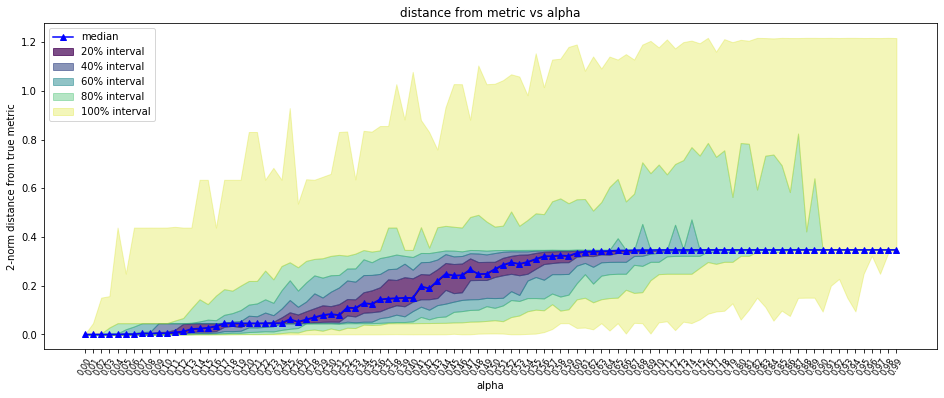

In [ ]:
num_itr = 500
step = 0.01

re_arr = np.zeros((100,num_itr))

for itr in range(num_itr):
  for lp, al in enumerate(np.arange(0., 1., step)):
    m,C = max_quasiconcave_metric(1e-4, al)
    # re.append(abs(phi2(m[0], m[1])-phi2(m_star[0], m_star[1])))
    t = np.arccos(m[0])
    if t > np.pi/2:
      t = np.pi*2-t
    re_arr[lp][itr] = np.linalg.norm(t-t_true)

re_max = np.amax(re_arr, 1)
re_min = np.amin(re_arr, 1)
re_mean = np.mean(re_arr, 1)
re_median = np.median(re_arr, 1)

fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

# ax.plot(np.arange(0., 1., step), re_max, "-", color='b', alpha=0.2) # plot maximum deviation
# ax.plot(np.arange(0., 1., step), re_min, "-", color='b', alpha=0.2) # plot minimum deviation
ax.plot(np.arange(0., 1., step), re_median, "^-", color='b', alpha=1, label='median') # plot mean relative error

cm = plt.get_cmap('viridis')
i=0
up_prev = re_median
low_prev = re_median
for i,pct in enumerate(range(40, 0, -10)):

  re_up = np.percentile(re_arr, 100-pct, 1)
  re_low = np.percentile(re_arr, pct, 1)
  ax.fill_between(np.arange(0., 1., step), re_up, up_prev, color=cm.colors[i*60], alpha=pct/100+0.3, label=str(100-2*pct)+'% interval')
  ax.fill_between(np.arange(0., 1., step), re_low, low_prev, color=cm.colors[i*60], alpha=pct/100+0.3)
  up_prev = re_up
  low_prev = re_low

ax.fill_between(np.arange(0., 1., step), re_max, up_prev, color=cm.colors[(i+1)*60], alpha=0.3, label='100% interval')
ax.fill_between(np.arange(0., 1., step), re_min, low_prev, color=cm.colors[(i+1)*60], alpha=0.3)

# plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 1, step=step), rotation=60, size="small")
plt.title("distance from metric vs alpha")
plt.xlabel("alpha")
plt.ylabel("2-norm distance from true metric")
plt.legend(loc='upper left')
plt.show()

In [ ]:
re_max = np.amax(re_arr, 1)
re_min = np.amin(re_arr, 1)
re_mean = np.mean(re_arr, 1)
re_median = np.median(re_arr, 1)

fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

# ax.plot(np.arange(0., 1., step), re_max, "-", color='b', alpha=0.2) # plot maximum deviation
# ax.plot(np.arange(0., 1., step), re_min, "-", color='b', alpha=0.2) # plot minimum deviation
ax.plot(np.arange(0., 1., step), re_median, "^-", color='b', alpha=1, label='median') # plot mean relative error

cm = plt.get_cmap('viridis')
i=0
up_prev = re_median
low_prev = re_median
for i,pct in enumerate(range(40, 0, -10)):

  re_up = np.percentile(re_arr, 100-pct, 1)
  re_low = np.percentile(re_arr, pct, 1)
  ax.fill_between(np.arange(0., 1., step), re_up, up_prev, color=cm.colors[i*60], alpha=pct/100+0.3, label=str(100-2*pct)+'% interval')
  ax.fill_between(np.arange(0., 1., step), re_low, low_prev, color=cm.colors[i*60], alpha=pct/100+0.3)
  up_prev = re_up
  low_prev = re_low

ax.fill_between(np.arange(0., 1., step), re_max, up_prev, color=cm.colors[(i+1)*60], alpha=0.3, label='100% interval')
ax.fill_between(np.arange(0., 1., step), re_min, low_prev, color=cm.colors[(i+1)*60], alpha=0.3)

# plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 1, step=step), rotation=60, size="small")
plt.title("distance from metric vs alpha")
plt.xlabel("alpha")
plt.ylabel("2-norm distance from true metric")
plt.legend(loc='upper left')
plt.show()